<a href="https://colab.research.google.com/github/PeterDeJin/log_return/blob/main/log_return_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-3302301816.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_returns_first_year = data_first_year.pct_change().fillna(method='ffill')
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-3302301816.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_returns_second_year = data_second_year.pct_change().fillna(method='ffill')
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-3302301816.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  paths[

stock_index 0 num_paths 4999
stock_index 1 num_paths 4999
stock_index 2 num_paths 4999
stock_index 3 num_paths 4999
stock_index 4 num_paths 4999
stock_index 5 num_paths 4999
stock_index 6 num_paths 4999
stock_index 7 num_paths 4999
stock_index 8 num_paths 4999
stock_index 9 num_paths 4999
stock_index 0 num_paths 4999
stock_index 1 num_paths 4999
stock_index 2 num_paths 4999
stock_index 3 num_paths 4999
stock_index 4 num_paths 4999
stock_index 5 num_paths 4999
stock_index 6 num_paths 4999
stock_index 7 num_paths 4999
stock_index 8 num_paths 4999
stock_index 9 num_paths 4999
stock_index 0 num_paths 4999
stock_index 1 num_paths 4999
stock_index 2 num_paths 4999
stock_index 3 num_paths 4999
stock_index 4 num_paths 4999
stock_index 5 num_paths 4999
stock_index 6 num_paths 4999
stock_index 7 num_paths 4999
stock_index 8 num_paths 4999
stock_index 9 num_paths 4999
stock_index 0 num_paths 4999
stock_index 1 num_paths 4999
stock_index 2 num_paths 4999
stock_index 3 num_paths 4999
stock_index 4 

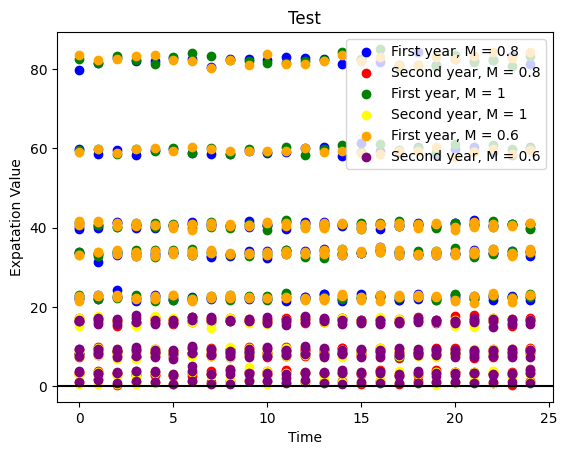

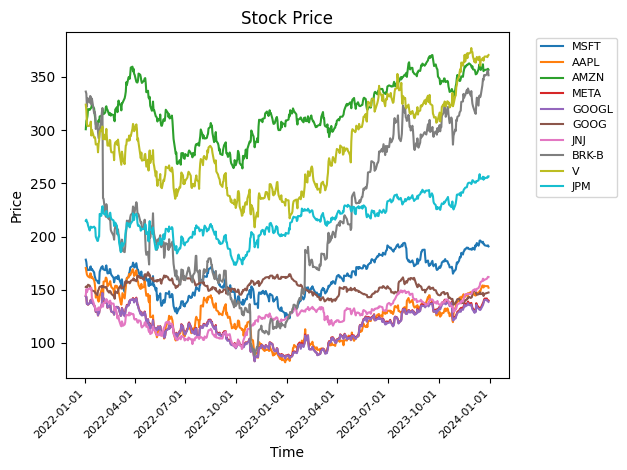

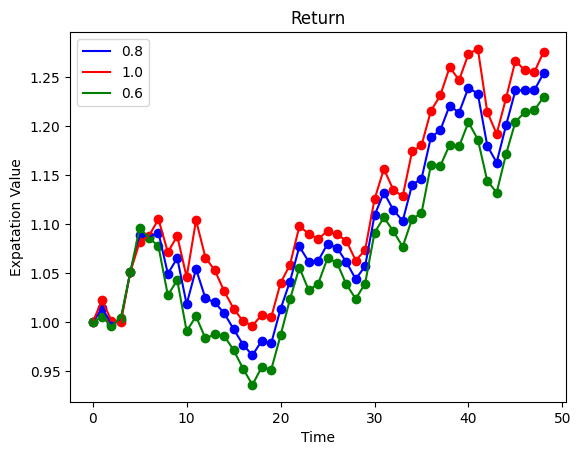

                 Max Drawdown  Log Return  Variances  Sharpe Ratio  \
First Year          -0.114494    0.060633   0.001386      0.582796   
Second Year         -0.114494    0.225978   0.007180      1.532246   
First Year M1       -0.098259    0.081516   0.001384      0.734401   
Second Year M1      -0.098259    0.243358   0.008025      1.574825   
First Year M06      -0.145904    0.038424   0.001766      0.379926   
Second Year M06     -0.145904    0.206604   0.006548      1.373438   

                 Cumulative Rate of Return (%)  
First Year                            6.250879  
Second Year                          25.354750  
First Year M1                         8.493065  
Second Year M1                       27.552501  
First Year M06                        3.917161  
Second Year M06                      22.949541  


In [1]:
#最終版本 有年化 group_size = 10
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib.dates as mdates

# 選擇2022年12月S&P500前十權重的股票
tickers = ['MSFT', 'AAPL', 'AMZN', 'META', 'GOOGL', 'GOOG', 'JNJ', 'BRK-B', 'V', 'JPM']
start_date = '2022-01-01'
end_date = '2023-01-01'
data_first_year = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
daily_returns_first_year = data_first_year.pct_change().fillna(method='ffill')
mean_returns_first_year = daily_returns_first_year.mean()
std_returns_first_year = daily_returns_first_year.std()

tickers = ['MSFT', 'AAPL', 'AMZN', 'META', 'GOOGL', 'GOOG', 'JNJ', 'BRK-B', 'V', 'JPM']
start_date = '2023-01-01'
end_date = '2024-01-03'
data_second_year = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
daily_returns_second_year = data_second_year.pct_change().fillna(method='ffill')
mean_returns_second_year = daily_returns_second_year.mean()
std_returns_second_year = daily_returns_second_year.std()

tickers = ['MSFT', 'AAPL', 'AMZN', 'META', 'GOOGL', 'GOOG', 'JNJ', 'BRK-B', 'V', 'JPM']
start_date = '2022-01-01'
end_date = '2024-01-01'
data_All = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

def brownian(mean, std_dev, data, group_size, M = 0.8, num_paths = 5000):
    np.random.seed()
    T = 1.0
    dt = T / len(data.values)
    t = np.linspace(0, T, len(data.values))
    paths = np.zeros((len(tickers),num_paths, len(data.values)))
    predict_return = np.zeros([num_paths, (len(data.values)//group_size), len(tickers)])

    for stock_index in range(len(tickers)):
        paths[stock_index, : , 0] = data.iloc[0, stock_index]
        for i in range(num_paths):
            # mean = (1 + mean[stock_index]) ** 252 - 1
            # std_dev = std_dev[stock_index] * np.sqrt(252)
            for j in range(1, len(data.values)):
                dW = np.random.randn() * np.sqrt(dt)
                paths[stock_index,i, j] = paths[stock_index,i, j-1] * np.exp((((1 + mean[stock_index]) ** 252 - 1) - 0.5 * (std_dev[stock_index] * np.sqrt(252))**2) * dt + std_dev[stock_index] * np.sqrt(252) * dW)
            for k in range(0, len(data.values) - group_size , group_size):
                returns_sum = 0
                for m in range(group_size):
                    returns_sum += (paths[stock_index, i, k + m + 1] - paths[stock_index, i, k + m]) / paths[stock_index, i, k + m]

                predict_return[i, k//group_size, stock_index] = returns_sum / group_size
        print("stock_index",stock_index,"num_paths",i)

    x = cp.Variable(len(tickers))
    daily_return_value = [0]*(len(data.values)//group_size)
    daily_return_result = [0]*(len(data.values)//group_size)
    for i in range (len(data.values)//(group_size)):
        constraints = [cp.sum(x) == 1, x >= 0.00000001, x <= M ]
        r = predict_return[:, i, :]
        y = cp.sum(cp.log(1 + r @ x))
        objective = cp.Minimize(-1/num_paths * y)
        prob = cp.Problem(objective, constraints)
        result =prob.solve(solver=cp.SCS)
        daily_return_value[i] = x.value
        daily_return_result[i] = result

    return daily_return_value, predict_return, paths

def function_point(daily_return_value,predict_return):
    x_data = []
    y_data = []

    for t in range(len(daily_return_value)):
        for j in range(len(tickers)):
            if j == np.argmax(daily_return_value[t]):
                continue
            x_data.append(t)
            y_value = 0
            for k in range(len(predict_return)):
                y_value += (predict_return[k][t][np.argmax(daily_return_value[t])] - predict_return[k][t][j]) / (
                          1 + daily_return_value[t] @ predict_return[k][t])
                # y_value = y_value/len(predict_return)
            y_data.append(y_value)

    return x_data,y_data

def function_line(daily_return_value, group_size, daily_returns, value):
    v = value.copy()
    for i in range(1,len(daily_return_value)):
          R_n = [1] * len(tickers)
          for j in range(len(tickers)):
              for k in range(i*group_size+1,(i+1)*group_size+1):
                  R_n[j] = (1 + daily_returns.values[k][j])*R_n[j]
              R_n[j] = R_n[j] - 1
          v_1 = (1 +(np.dot(daily_return_value[i], R_n))) * v[-1]
          v.append(v_1)
    return v

def check_function(daily_return_value1, daily_return_value2):
    a = 1
    for t in range(len(daily_return_value1)):
        if np.argmax(daily_return_value1[t]) != np.argmax(daily_return_value2[t]):
            print("time:",t)
            print("daily return value1",np.argmax(daily_return_value1[t]))
            print("daily return correct value",np.argmax(daily_return_value2[t]))
            a = 0
    if a == 1:
        print("All correct")

def Cumulative_rate_of_return(y_data):
    Cumulative_rate_of_return = (y_data[-1] - y_data[0])/y_data[0]
    return Cumulative_rate_of_return

def variances(y_data):
    variances = np.var(y_data)
    return variances

def log_return(y_data):
    log_return = np.log(y_data[-1]/y_data[0])
    return log_return

def sharpe_ratio(y_data, risk_free_rate=0):
    daily_returns = [0]*(len(y_data)-1)
    for i in range(len(y_data)-1):
        daily_returns[i] = (y_data[i+1] - y_data[i])/y_data[i]
        (daily_returns[i] - risk_free_rate) / len(y_data)
    excess_returns = np.array(daily_returns)
    mean_excess_return = excess_returns.mean() * len(y_data)
    annual_std = excess_returns.std() * np.sqrt(len(y_data))
    sharpe_ratio = mean_excess_return / annual_std
    return sharpe_ratio

def max_drawdown(y_data):
    y_data = pd.Series(y_data)
    cumulative_max = y_data.cummax()
    drawdown = (y_data - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    return max_drawdown

group_size = 10

daily_return_value_first_year, predict_return_first_year, path_first_year = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size)
daily_return_value_second_year, predict_return_second_year, path_second_year = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size)
daily_return_value_first_year_M1, predict_return_first_year_M1, path_first_year_M1 = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size, M = 1)
daily_return_value_second_year_M1, predict_return_second_year_M1, path_second_year_M1 = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size, M = 1)
daily_return_value_first_year_M06, predict_return_first_year_M06, path_first_year_M06 = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size, M = 0.6)
daily_return_value_second_year_M06, predict_return_second_year_M06, path_second_year_M06 = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size, M = 0.6)

print("Check First year M = 0.8 weight")
check_function(daily_return_value_first_year, daily_return_value_first_year_M1)
print("Check First year M = 0.6 weight")
check_function(daily_return_value_first_year_M06, daily_return_value_first_year_M1)
print("Check Second year M = 0.8 weight")
check_function(daily_return_value_second_year, daily_return_value_second_year_M1)
print("Check Second year M = 0.6 weight")
check_function(daily_return_value_second_year_M06, daily_return_value_second_year_M1)
# print("daily_return_value_first_year",daily_return_value_first_year)
# print("daily_return_value_first_year_M1",daily_return_value_first_year_M1)
# print("daily_return_value_second_year",daily_return_value_second_year)
# print("daily_return_value_second_year_M1",daily_return_value_second_year_M1)

x_data_first_year, y_data_first_year = function_point(daily_return_value_first_year,predict_return_first_year)
x_data_second_year, y_data_second_year = function_point(daily_return_value_second_year,predict_return_second_year)
x_data_first_year_M1, y_data_first_year_M1 = function_point(daily_return_value_first_year_M1,predict_return_first_year_M1)
x_data_second_year_M1, y_data_second_year_M1 = function_point(daily_return_value_second_year_M1,predict_return_second_year_M1)
x_data_first_year_M06, y_data_first_year_M06 = function_point(daily_return_value_first_year_M06,predict_return_first_year_M06)
x_data_second_year_M06, y_data_second_year_M06 = function_point(daily_return_value_second_year_M06,predict_return_second_year_M06)

value_first_year = function_line(daily_return_value_first_year, group_size, daily_returns_first_year, [1])
value_second_year = function_line(daily_return_value_second_year, group_size, daily_returns_second_year, value_first_year)
value_first_year_M1 = function_line(daily_return_value_first_year_M1, group_size, daily_returns_first_year, [1])
value_second_year_M1 = function_line(daily_return_value_second_year_M1, group_size, daily_returns_second_year, value_first_year_M1)
value_first_year_M06 = function_line(daily_return_value_first_year_M06, group_size, daily_returns_first_year, [1])
value_second_year_M06 = function_line(daily_return_value_second_year_M06, group_size, daily_returns_second_year, value_first_year_M06)

plt.scatter(x_data_first_year, y_data_first_year, c='blue', marker='o', label = "First year, M = 0.8")
plt.scatter(x_data_second_year, y_data_second_year, c='red', marker='o', label = "Second year, M = 0.8")
plt.scatter(x_data_first_year_M1, y_data_first_year_M1, c='green', marker='o', label = "First year, M = 1")
plt.scatter(x_data_second_year_M1, y_data_second_year_M1, c='yellow', marker='o', label = "Second year, M = 1")
plt.scatter(x_data_first_year_M06, y_data_first_year_M06, c='orange', marker='o', label = "First year, M = 0.6")
plt.scatter(x_data_second_year_M06, y_data_second_year_M06, c='purple', marker='o', label = "Second year, M = 0.6")
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
# plt.ylim(-0.025, 0.025)
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Expatation Value')
plt.show()

for i in range(len(tickers)):
    plt.plot(data_All.index, data_All.iloc[:, i], label=tickers[i])
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
plt.title('Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right', fontsize=8, fontstyle='normal')
plt.tight_layout()
plt.show()

for i in range(len(value_second_year)):
    plt.plot(i,value_second_year[i], 'bo')
    plt.plot(i,value_second_year_M1[i], 'ro')
    plt.plot(i,value_second_year_M06[i], 'go')
plt.plot(range(len(value_second_year)), value_second_year, 'b-', label = 0.8)
plt.plot(range(len(value_second_year_M1)), value_second_year_M1, 'r-', label = 1.0)
plt.plot(range(len(value_second_year_M06)), value_second_year_M06, 'g-', label = 0.6)
plt.legend()
plt.title('Return')
plt.xlabel('Time')
plt.ylabel('Expatation Value')
plt.show()

# print(len(value_first_year))
# print(len(value_second_year))
# print((value_first_year_M1))
# print((value_second_year_M1))
# print((value_first_year_M06))
# print((value_second_year_M06))
# print("x_data_first_year",x_data_first_year,"y_data_first_year",y_data_first_year)
# print("y_data_second_year",y_data_second_year)

results = {
    'Max Drawdown': [
        max_drawdown(value_first_year),
        max_drawdown(value_second_year),
        max_drawdown(value_first_year_M1),
        max_drawdown(value_second_year_M1),
        max_drawdown(value_first_year_M06),
        max_drawdown(value_second_year_M06)
    ],
    'Log Return': [
        log_return(value_first_year),
        log_return(value_second_year),
        log_return(value_first_year_M1),
        log_return(value_second_year_M1),
        log_return(value_first_year_M06),
        log_return(value_second_year_M06)
    ],
    'Variances': [
        variances(value_first_year),
        variances(value_second_year),
        variances(value_first_year_M1),
        variances(value_second_year_M1),
        variances(value_first_year_M06),
        variances(value_second_year_M06)
    ],
    'Sharpe Ratio': [
        sharpe_ratio(value_first_year),
        sharpe_ratio(value_second_year),
        sharpe_ratio(value_first_year_M1),
        sharpe_ratio(value_second_year_M1),
        sharpe_ratio(value_first_year_M06),
        sharpe_ratio(value_second_year_M06)
    ],
    'Cumulative Rate of Return (%)': [
        Cumulative_rate_of_return(value_first_year) * 100,
        Cumulative_rate_of_return(value_second_year) * 100,
        Cumulative_rate_of_return(value_first_year_M1) * 100,
        Cumulative_rate_of_return(value_second_year_M1) * 100,
        Cumulative_rate_of_return(value_first_year_M06) * 100,
        Cumulative_rate_of_return(value_second_year_M06) * 100
    ]
}
df_results = pd.DataFrame(results, index=['First Year','Second Year','First Year M1','Second Year M1','First Year M06','Second Year M06'])
print(df_results)

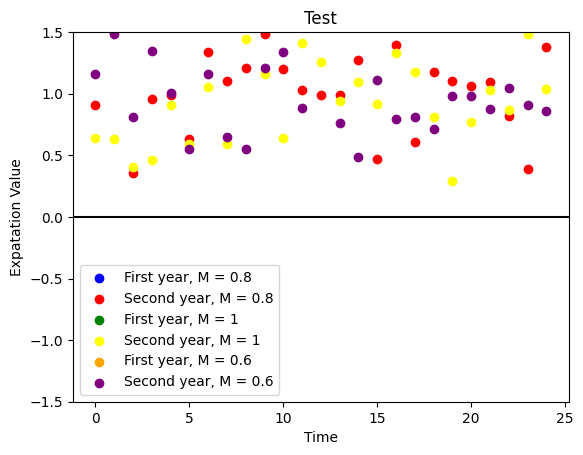

In [2]:
plt.scatter(x_data_first_year, y_data_first_year, c='blue', marker='o', label = "First year, M = 0.8")
plt.scatter(x_data_second_year, y_data_second_year, c='red', marker='o', label = "Second year, M = 0.8")
plt.scatter(x_data_first_year_M1, y_data_first_year_M1, c='green', marker='o', label = "First year, M = 1")
plt.scatter(x_data_second_year_M1, y_data_second_year_M1, c='yellow', marker='o', label = "Second year, M = 1")
plt.scatter(x_data_first_year_M06, y_data_first_year_M06, c='orange', marker='o', label = "First year, M = 0.6")
plt.scatter(x_data_second_year_M06, y_data_second_year_M06, c='purple', marker='o', label = "Second year, M = 0.6")
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
plt.ylim(-1.5, 1.5)
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Expatation Value')
plt.show()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-3784186075.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drift = ((1 + mean[stock_index]) ** 252 - 1) - 0.5 * (std_dev[stock_index] * np.sqrt(252))**2
/tmp/ipython-input-3784186075.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diffusion_const = std_dev[stock_index] * np.sqrt(252)


Processing First Year...
Start simulation (M=0.8)...
Start Optimization (M=0.8)...
Start simulation (M=1)...
Start Optimization (M=1)...
Start simulation (M=0.6)...
Start Optimization (M=0.6)...
Processing Second Year...
Start simulation (M=0.8)...
Start Optimization (M=0.8)...
Start simulation (M=1)...
Start Optimization (M=1)...
Start simulation (M=0.6)...
Start Optimization (M=0.6)...

Check First year M = 0.8 vs M=1
time: 0
daily return value1 idx: 5
daily return correct value idx: 2
time: 7
daily return value1 idx: 2
daily return correct value idx: 5
time: 12
daily return value1 idx: 5
daily return correct value idx: 2
time: 20
daily return value1 idx: 2
daily return correct value idx: 5
time: 22
daily return value1 idx: 5
daily return correct value idx: 2
time: 23
daily return value1 idx: 2
daily return correct value idx: 5
Check First year M = 0.6 vs M=1
time: 0
daily return value1 idx: 5
daily return correct value idx: 2
time: 3
daily return value1 idx: 2
daily return correct v

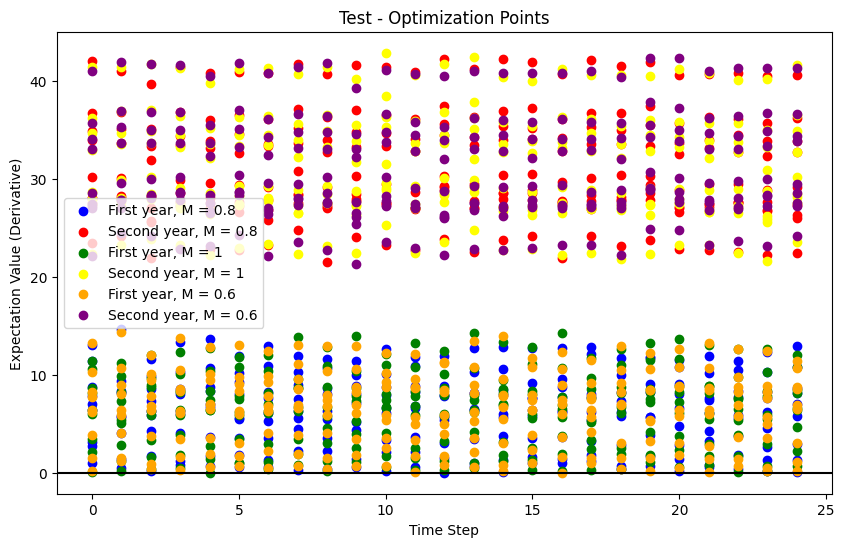

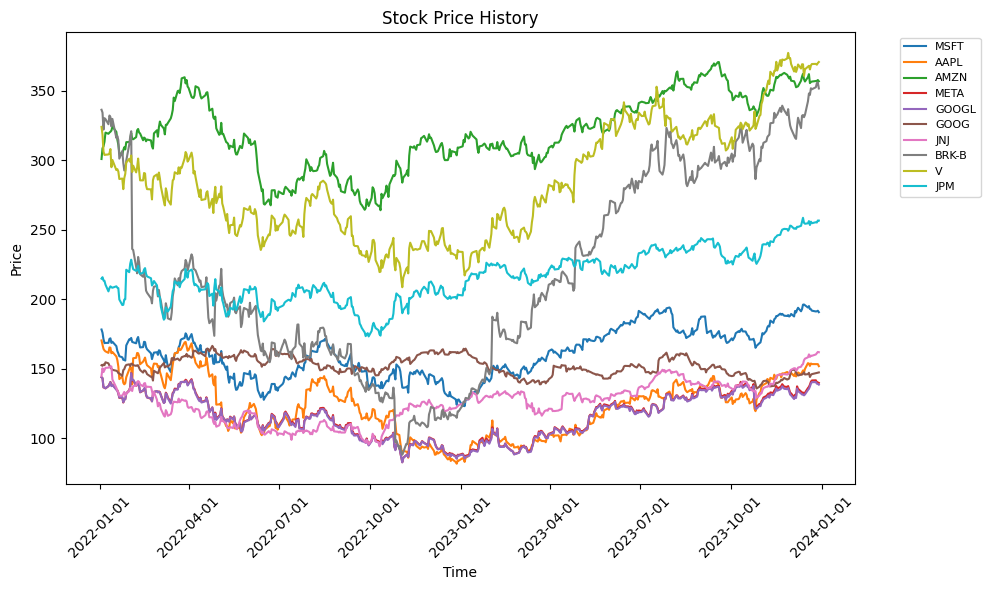

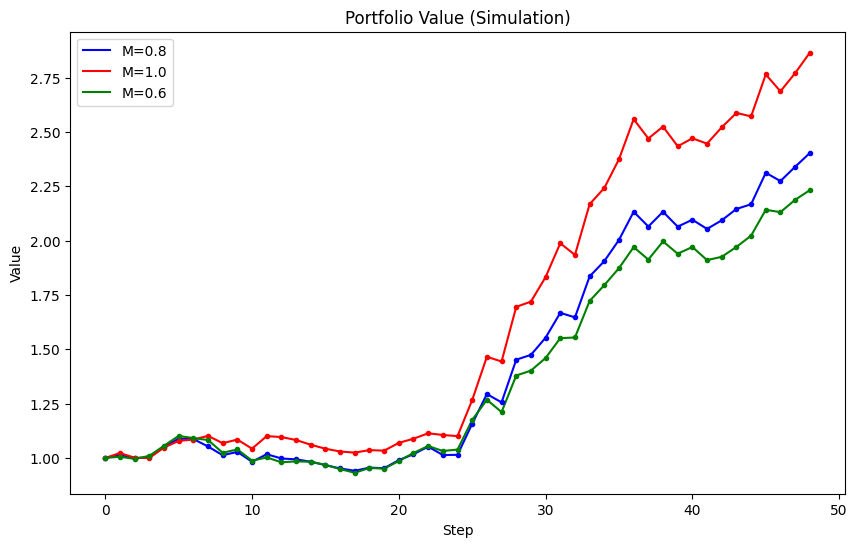

                     Max Drawdown  Log Return  Variances  Sharpe Ratio  \
First Year (M=0.8)      -0.135749    0.014275   0.001460      0.179387   
Second Year (M=0.8)     -0.135749    0.876876   0.262583      2.998420   
First Year (M=1.0)      -0.069863    0.095795   0.001223      0.917932   
Second Year (M=1.0)     -0.069863    1.052566   0.449817      3.310236   
First Year (M=0.6)      -0.153739    0.037930   0.001953      0.367464   
Second Year (M=0.6)     -0.153739    0.803067   0.198122      3.014933   

                     Cumulative Rate of Return (%)  
First Year (M=0.8)                        1.437717  
Second Year (M=0.8)                     140.337951  
First Year (M=1.0)                       10.053294  
Second Year (M=1.0)                     186.499261  
First Year (M=0.6)                        3.865801  
Second Year (M=0.6)                     123.237658  


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib.dates as mdates

# 設定隨機種子以確保結果可重現 (可選)
np.random.seed(42)

# --- 資料下載區塊 ---
tickers = ['MSFT', 'AAPL', 'AMZN', 'META', 'GOOGL', 'GOOG', 'JNJ', 'BRK-B', 'V', 'JPM']

# 第一年資料
start_date = '2022-01-01'
end_date = '2023-01-01'
data_first_year = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
daily_returns_first_year = data_first_year.pct_change().ffill() # 更新語法
mean_returns_first_year = daily_returns_first_year.mean()
std_returns_first_year = daily_returns_first_year.std()

# 第二年資料
start_date = '2023-01-01'
end_date = '2024-01-03'
data_second_year = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
daily_returns_second_year = data_second_year.pct_change().ffill() # 更新語法
mean_returns_second_year = daily_returns_second_year.mean()
std_returns_second_year = daily_returns_second_year.std()

# 全部資料 (用於畫圖)
start_date = '2022-01-01'
end_date = '2024-01-01'
data_All = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# --- 核心函數：布朗運動模擬與最佳化 ---
def brownian(mean, std_dev, data, group_size, M = 0.8, num_paths = 5000):
    # np.random.seed() # 如果需要固定結果，請填入數字，如 np.random.seed(42)
    T = 1.0
    dt = T / len(data.values)

    # 初始化路徑矩陣
    paths = np.zeros((len(tickers), num_paths, len(data.values)))
    predict_return = np.zeros([num_paths, (len(data.values)//group_size), len(tickers)])

    # 1. 蒙地卡羅模擬 (生成路徑)
    print(f"Start simulation (M={M})...")
    for stock_index in range(len(tickers)):
        paths[stock_index, : , 0] = data.iloc[0, stock_index]
        for i in range(num_paths):
            # 這裡計算 drift 和 diffusion
            drift = ((1 + mean[stock_index]) ** 252 - 1) - 0.5 * (std_dev[stock_index] * np.sqrt(252))**2
            diffusion_const = std_dev[stock_index] * np.sqrt(252)

            for j in range(1, len(data.values)):
                dW = np.random.randn() * np.sqrt(dt)
                paths[stock_index,i, j] = paths[stock_index,i, j-1] * np.exp(drift * dt + diffusion_const * dW)

            # 計算分組回報
            for k in range(0, len(data.values) - group_size , group_size):
                returns_sum = 0
                for m in range(group_size):
                    returns_sum += (paths[stock_index, i, k + m + 1] - paths[stock_index, i, k + m]) / paths[stock_index, i, k + m]

                predict_return[i, k//group_size, stock_index] = returns_sum / group_size
        # 進度提示
        # print(f"Stock {tickers[stock_index]} simulation done.")

    # 2. CVXPY 最佳化 (向量化版本)
    x = cp.Variable(len(tickers))
    daily_return_value = [0]*(len(data.values)//group_size)
    daily_return_result = [0]*(len(data.values)//group_size)

    print(f"Start Optimization (M={M})...")
    for i in range (len(data.values)//(group_size)):
        constraints = [cp.sum(x) == 1, x >= 0.00000001, x <= M ]

        # --- 修正開始：使用矩陣運算取代迴圈 ---
        # 取出該時間段所有路徑的預測回報 (shape: 5000 x 10)
        R_matrix = predict_return[:, i, :]

        # 計算投資組合回報 (shape: 5000,)
        # 這裡利用矩陣乘法一次算出所有路徑的組合回報
        port_returns = R_matrix @ x

        # 計算對數效用函數 (一次處理整個向量)
        y = cp.sum(cp.log(1 + port_returns))

        objective = cp.Minimize(-1/num_paths * y)
        # --- 修正結束 ---

        prob = cp.Problem(objective, constraints)

        # 使用 ECOS 或 SCS 求解器以增加穩定性
        try:
            result = prob.solve(solver=cp.ECOS)
        except:
            result = prob.solve(solver=cp.SCS)

        daily_return_value[i] = x.value
        daily_return_result[i] = result

    return daily_return_value, predict_return, paths

# --- 輔助函數 ---
def function_point(daily_return_value, predict_return):
    x_data = []
    y_data = []

    for t in range(len(daily_return_value)):
        # 找出權重最大的股票
        max_idx = np.argmax(daily_return_value[t])

        for j in range(len(tickers)):
            if j == max_idx:
                continue
            x_data.append(t)
            y_value = 0

            # 這裡也可以向量化加速，但維持原樣以確保邏輯正確
            # 分子：最大權重股的回報 - 其他股的回報
            diff = predict_return[:, t, max_idx] - predict_return[:, t, j]
            # 分母：1 + 投資組合回報
            denom = 1 + (predict_return[:, t, :] @ daily_return_value[t])

            y_value = np.sum(diff / denom)
            y_data.append(y_value)

    return x_data, y_data

def function_line(daily_return_value, group_size, daily_returns, value):
    v = value.copy()
    for i in range(1, len(daily_return_value)):
          R_n = np.ones(len(tickers)) # 使用 numpy 初始化
          for j in range(len(tickers)):
              # 計算區間內的累積回報
              start_idx = i * group_size + 1
              end_idx = (i + 1) * group_size + 1
              if end_idx > len(daily_returns): break # 邊界檢查

              # 用 numpy 運算加速乘積
              subset = daily_returns.values[start_idx:end_idx, j]
              R_n[j] = np.prod(1 + subset) - 1

          v_1 = (1 + (np.dot(daily_return_value[i], R_n))) * v[-1]
          v.append(v_1)
    return v

def check_function(daily_return_value1, daily_return_value2):
    a = 1
    for t in range(len(daily_return_value1)):
        # 加入 None 檢查以防求解失敗
        if daily_return_value1[t] is None or daily_return_value2[t] is None:
            continue

        if np.argmax(daily_return_value1[t]) != np.argmax(daily_return_value2[t]):
            print("time:", t)
            print("daily return value1 idx:", np.argmax(daily_return_value1[t]))
            print("daily return correct value idx:", np.argmax(daily_return_value2[t]))
            a = 0
    if a == 1:
        print("All correct")

def Cumulative_rate_of_return(y_data):
    return (y_data[-1] - y_data[0]) / y_data[0]

def variances(y_data):
    return np.var(y_data)

def log_return(y_data):
    return np.log(y_data[-1] / y_data[0])

def sharpe_ratio(y_data, risk_free_rate=0):
    y_data = np.array(y_data)
    daily_returns = (y_data[1:] - y_data[:-1]) / y_data[:-1]
    excess_returns = daily_returns - (risk_free_rate / 252) # 假設無風險利率是年化

    mean_excess_return = excess_returns.mean() * len(y_data) # 這裡依您的邏輯 * len
    annual_std = excess_returns.std() * np.sqrt(len(y_data))

    if annual_std == 0: return 0
    sharpe_ratio = mean_excess_return / annual_std
    return sharpe_ratio

def max_drawdown(y_data):
    y_data = pd.Series(y_data)
    cumulative_max = y_data.cummax()
    drawdown = (y_data - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    return max_drawdown

# --- 主程式執行區塊 ---

group_size = 10

# 執行模型 (這部分會花一點時間，但比原本快很多)
print("Processing First Year...")
daily_return_value_first_year, predict_return_first_year, path_first_year = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size)
daily_return_value_first_year_M1, predict_return_first_year_M1, path_first_year_M1 = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size, M = 1)
daily_return_value_first_year_M06, predict_return_first_year_M06, path_first_year_M06 = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size, M = 0.6)

print("Processing Second Year...")
daily_return_value_second_year, predict_return_second_year, path_second_year = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size)
daily_return_value_second_year_M1, predict_return_second_year_M1, path_second_year_M1 = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size, M = 1)
daily_return_value_second_year_M06, predict_return_second_year_M06, path_second_year_M06 = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size, M = 0.6)

# --- 檢查與繪圖 ---
print("\nCheck First year M = 0.8 vs M=1")
check_function(daily_return_value_first_year, daily_return_value_first_year_M1)
print("Check First year M = 0.6 vs M=1")
check_function(daily_return_value_first_year_M06, daily_return_value_first_year_M1)
print("Check Second year M = 0.8 vs M=1")
check_function(daily_return_value_second_year, daily_return_value_second_year_M1)
print("Check Second year M = 0.6 vs M=1")
check_function(daily_return_value_second_year_M06, daily_return_value_second_year_M1)

# 計算點位 (Function Point)
x_data_first_year, y_data_first_year = function_point(daily_return_value_first_year,predict_return_first_year)
x_data_second_year, y_data_second_year = function_point(daily_return_value_second_year,predict_return_second_year)
x_data_first_year_M1, y_data_first_year_M1 = function_point(daily_return_value_first_year_M1,predict_return_first_year_M1)
x_data_second_year_M1, y_data_second_year_M1 = function_point(daily_return_value_second_year_M1,predict_return_second_year_M1)
x_data_first_year_M06, y_data_first_year_M06 = function_point(daily_return_value_first_year_M06,predict_return_first_year_M06)
x_data_second_year_M06, y_data_second_year_M06 = function_point(daily_return_value_second_year_M06,predict_return_second_year_M06)

# 計算資金曲線 (Function Line)
value_first_year = function_line(daily_return_value_first_year, group_size, daily_returns_first_year, [1])
value_second_year = function_line(daily_return_value_second_year, group_size, daily_returns_second_year, value_first_year)
value_first_year_M1 = function_line(daily_return_value_first_year_M1, group_size, daily_returns_first_year, [1])
value_second_year_M1 = function_line(daily_return_value_second_year_M1, group_size, daily_returns_second_year, value_first_year_M1)
value_first_year_M06 = function_line(daily_return_value_first_year_M06, group_size, daily_returns_first_year, [1])
value_second_year_M06 = function_line(daily_return_value_second_year_M06, group_size, daily_returns_second_year, value_first_year_M06)

# --- 繪圖 1: 散點圖 ---
plt.figure(figsize=(10, 6))
plt.scatter(x_data_first_year, y_data_first_year, c='blue', marker='o', label = "First year, M = 0.8")
plt.scatter(x_data_second_year, y_data_second_year, c='red', marker='o', label = "Second year, M = 0.8")
plt.scatter(x_data_first_year_M1, y_data_first_year_M1, c='green', marker='o', label = "First year, M = 1")
plt.scatter(x_data_second_year_M1, y_data_second_year_M1, c='yellow', marker='o', label = "Second year, M = 1")
plt.scatter(x_data_first_year_M06, y_data_first_year_M06, c='orange', marker='o', label = "First year, M = 0.6")
plt.scatter(x_data_second_year_M06, y_data_second_year_M06, c='purple', marker='o', label = "Second year, M = 0.6")
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
plt.title('Test - Optimization Points')
plt.xlabel('Time Step')
plt.ylabel('Expectation Value (Derivative)')
plt.show()

# --- 繪圖 2: 股價走勢 ---
plt.figure(figsize=(10, 6))
for i in range(len(tickers)):
    plt.plot(data_All.index, data_All.iloc[:, i], label=tickers[i])
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
plt.title('Stock Price History')
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 繪圖 3: 回報曲線 ---
plt.figure(figsize=(10, 6))
# 這裡用 range 當 x 軸，確保長度一致
plt.plot(range(len(value_second_year)), value_second_year, 'b-', label = 'M=0.8')
plt.plot(range(len(value_second_year_M1)), value_second_year_M1, 'r-', label = 'M=1.0')
plt.plot(range(len(value_second_year_M06)), value_second_year_M06, 'g-', label = 'M=0.6')

# 加上點標記
plt.plot(range(len(value_second_year)), value_second_year, 'bo', markersize=3)
plt.plot(range(len(value_second_year_M1)), value_second_year_M1, 'ro', markersize=3)
plt.plot(range(len(value_second_year_M06)), value_second_year_M06, 'go', markersize=3)

plt.legend()
plt.title('Portfolio Value (Simulation)')
plt.xlabel('Step')
plt.ylabel('Value')
plt.show()

# --- 結果表格 ---
results = {
    'Max Drawdown': [
        max_drawdown(value_first_year),
        max_drawdown(value_second_year),
        max_drawdown(value_first_year_M1),
        max_drawdown(value_second_year_M1),
        max_drawdown(value_first_year_M06),
        max_drawdown(value_second_year_M06)
    ],
    'Log Return': [
        log_return(value_first_year),
        log_return(value_second_year),
        log_return(value_first_year_M1),
        log_return(value_second_year_M1),
        log_return(value_first_year_M06),
        log_return(value_second_year_M06)
    ],
    'Variances': [
        variances(value_first_year),
        variances(value_second_year),
        variances(value_first_year_M1),
        variances(value_second_year_M1),
        variances(value_first_year_M06),
        variances(value_second_year_M06)
    ],
    'Sharpe Ratio': [
        sharpe_ratio(value_first_year),
        sharpe_ratio(value_second_year),
        sharpe_ratio(value_first_year_M1),
        sharpe_ratio(value_second_year_M1),
        sharpe_ratio(value_first_year_M06),
        sharpe_ratio(value_second_year_M06)
    ],
    'Cumulative Rate of Return (%)': [
        Cumulative_rate_of_return(value_first_year) * 100,
        Cumulative_rate_of_return(value_second_year) * 100,
        Cumulative_rate_of_return(value_first_year_M1) * 100,
        Cumulative_rate_of_return(value_second_year_M1) * 100,
        Cumulative_rate_of_return(value_first_year_M06) * 100,
        Cumulative_rate_of_return(value_second_year_M06) * 100
    ]
}
df_results = pd.DataFrame(results, index=[
    'First Year (M=0.8)', 'Second Year (M=0.8)',
    'First Year (M=1.0)', 'Second Year (M=1.0)',
    'First Year (M=0.6)', 'Second Year (M=0.6)'
])
print(df_results)

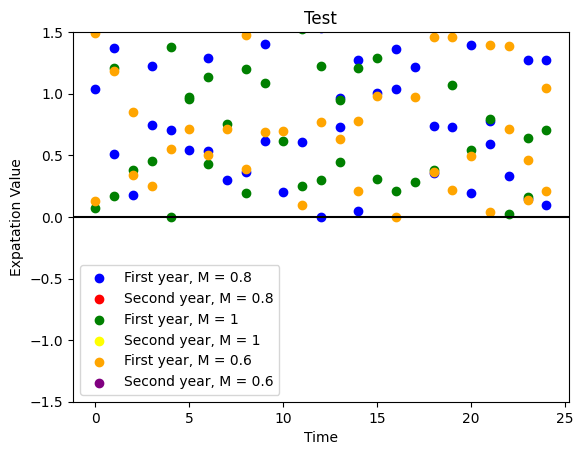

In [8]:
plt.scatter(x_data_first_year, y_data_first_year, c='blue', marker='o', label = "First year, M = 0.8")
plt.scatter(x_data_second_year, y_data_second_year, c='red', marker='o', label = "Second year, M = 0.8")
plt.scatter(x_data_first_year_M1, y_data_first_year_M1, c='green', marker='o', label = "First year, M = 1")
plt.scatter(x_data_second_year_M1, y_data_second_year_M1, c='yellow', marker='o', label = "Second year, M = 1")
plt.scatter(x_data_first_year_M06, y_data_first_year_M06, c='orange', marker='o', label = "First year, M = 0.6")
plt.scatter(x_data_second_year_M06, y_data_second_year_M06, c='purple', marker='o', label = "Second year, M = 0.6")
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
plt.ylim(-1.5, 1.5)
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Expatation Value')
plt.show()

[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-4205227727.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_returns_first_year = data_first_year.pct_change().fillna(method='ffill')
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-4205227727.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_returns_second_year = data_second_year.pct_change().fillna(method='ffill')
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-4205227727.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  paths[

stock_index 0 num_paths 4999
stock_index 1 num_paths 4999
stock_index 2 num_paths 4999
stock_index 3 num_paths 4999
stock_index 4 num_paths 4999
stock_index 5 num_paths 4999
stock_index 6 num_paths 4999
stock_index 7 num_paths 4999
stock_index 8 num_paths 4999
stock_index 9 num_paths 4999


/usr/local/lib/python3.12/dist-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/usr/local/lib/python3.12/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


stock_index 0 num_paths 4999
stock_index 1 num_paths 4999
stock_index 2 num_paths 4999
stock_index 3 num_paths 4999
stock_index 4 num_paths 4999
stock_index 5 num_paths 4999
stock_index 6 num_paths 4999
stock_index 7 num_paths 4999
stock_index 8 num_paths 4999
stock_index 9 num_paths 4999
stock_index 0 num_paths 4999
stock_index 1 num_paths 4999
stock_index 2 num_paths 4999
stock_index 3 num_paths 4999
stock_index 4 num_paths 4999
stock_index 5 num_paths 4999
stock_index 6 num_paths 4999
stock_index 7 num_paths 4999
stock_index 8 num_paths 4999
stock_index 9 num_paths 4999
stock_index 0 num_paths 4999
stock_index 1 num_paths 4999
stock_index 2 num_paths 4999
stock_index 3 num_paths 4999
stock_index 4 num_paths 4999
stock_index 5 num_paths 4999
stock_index 6 num_paths 4999
stock_index 7 num_paths 4999
stock_index 8 num_paths 4999
stock_index 9 num_paths 4999
stock_index 0 num_paths 4999
stock_index 1 num_paths 4999
stock_index 2 num_paths 4999
stock_index 3 num_paths 4999
stock_index 4 

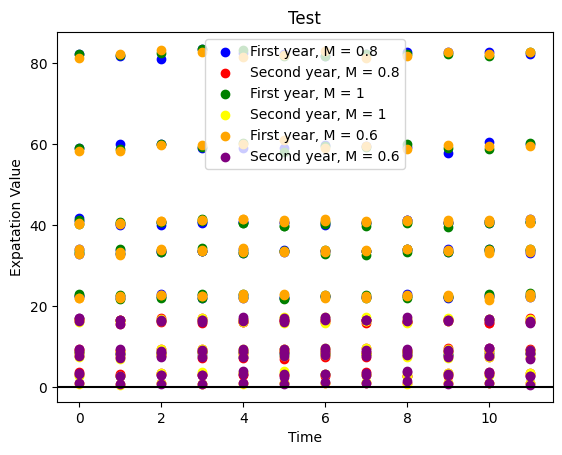

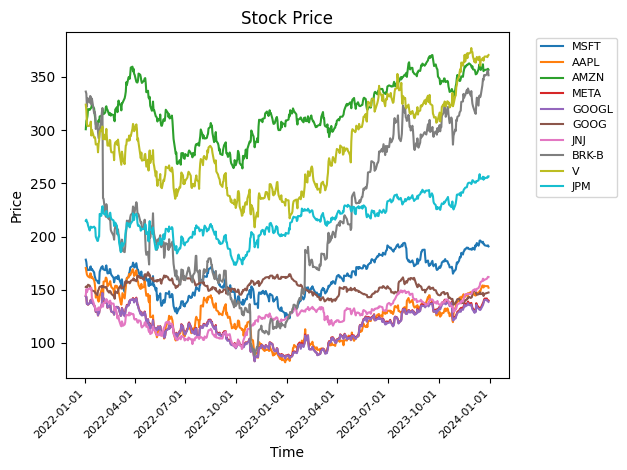

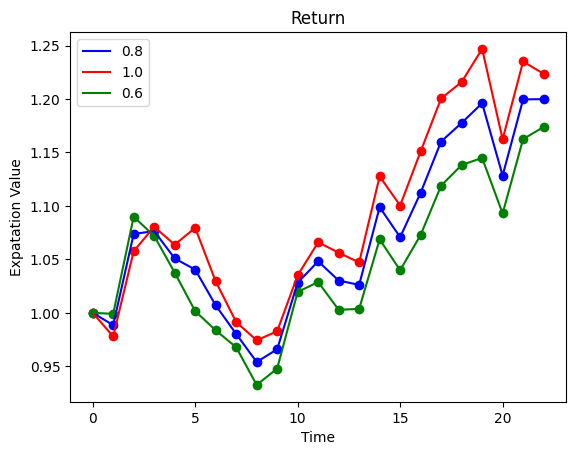

                 Max Drawdown  Log Return  Variances  Sharpe Ratio  \
First Year          -0.113776    0.047066   0.001557      0.462930   
Second Year         -0.113776    0.182203   0.005662      1.156747   
First Year M1       -0.098259    0.063887   0.001552      0.605775   
Second Year M1      -0.098259    0.201812   0.007370      1.224459   
First Year M06      -0.144390    0.028393   0.001994      0.286541   
Second Year M06     -0.144390    0.160243   0.004481      1.004648   

                 Cumulative Rate of Return (%)  
First Year                            4.819083  
Second Year                          19.985791  
First Year M1                         6.597174  
Second Year M1                       22.361761  
First Year M06                        2.880021  
Second Year M06                      17.379634  


In [9]:
#最終版本 有年化 group_size = 20
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib.dates as mdates

# 選擇2022年12月S&P500前十權重的股票
tickers = ['MSFT', 'AAPL', 'AMZN', 'META', 'GOOGL', 'GOOG', 'JNJ', 'BRK-B', 'V', 'JPM']
start_date = '2022-01-01'
end_date = '2023-01-01'
data_first_year = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
daily_returns_first_year = data_first_year.pct_change().fillna(method='ffill')
mean_returns_first_year = daily_returns_first_year.mean()
std_returns_first_year = daily_returns_first_year.std()

tickers = ['MSFT', 'AAPL', 'AMZN', 'META', 'GOOGL', 'GOOG', 'JNJ', 'BRK-B', 'V', 'JPM']
start_date = '2023-01-01'
end_date = '2024-01-03'
data_second_year = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
daily_returns_second_year = data_second_year.pct_change().fillna(method='ffill')
mean_returns_second_year = daily_returns_second_year.mean()
std_returns_second_year = daily_returns_second_year.std()

tickers = ['MSFT', 'AAPL', 'AMZN', 'META', 'GOOGL', 'GOOG', 'JNJ', 'BRK-B', 'V', 'JPM']
start_date = '2022-01-01'
end_date = '2024-01-01'
data_All = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

def brownian(mean, std_dev, data, group_size, M = 0.8, num_paths = 5000):
    np.random.seed()
    T = 1.0
    dt = T / len(data.values)
    t = np.linspace(0, T, len(data.values))
    paths = np.zeros((len(tickers),num_paths, len(data.values)))
    predict_return = np.zeros([num_paths, (len(data.values)//group_size), len(tickers)])

    for stock_index in range(len(tickers)):
        paths[stock_index, : , 0] = data.iloc[0, stock_index]
        for i in range(num_paths):
            # mean = (1 + mean[stock_index]) ** 252 - 1
            # std_dev = std_dev[stock_index] * np.sqrt(252)
            for j in range(1, len(data.values)):
                dW = np.random.randn() * np.sqrt(dt)
                paths[stock_index,i, j] = paths[stock_index,i, j-1] * np.exp((((1 + mean[stock_index]) ** 252 - 1) - 0.5 * (std_dev[stock_index] * np.sqrt(252))**2) * dt + std_dev[stock_index] * np.sqrt(252) * dW)
            for k in range(0, len(data.values) - group_size , group_size):
                returns_sum = 0
                for m in range(group_size):
                    returns_sum += (paths[stock_index, i, k + m + 1] - paths[stock_index, i, k + m]) / paths[stock_index, i, k + m]

                predict_return[i, k//group_size, stock_index] = returns_sum / group_size
        print("stock_index",stock_index,"num_paths",i)

    x = cp.Variable(len(tickers))
    daily_return_value = [0]*(len(data.values)//group_size)
    daily_return_result = [0]*(len(data.values)//group_size)
    for i in range (len(data.values)//(group_size)):
        constraints = [cp.sum(x) == 1, x >= 0.00000001, x <= M ]
        y = 0
        for j in range(num_paths):
            y += cp.log(1 + (predict_return[j, i, :] @ x))
        objective = cp.Minimize(-1/num_paths * y)
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        daily_return_value[i] = x.value
        daily_return_result[i] = result

    return daily_return_value, predict_return, paths

def function_point(daily_return_value,predict_return):
    x_data = []
    y_data = []

    for t in range(len(daily_return_value)):
        for j in range(len(tickers)):
            if j == np.argmax(daily_return_value[t]):
                continue
            x_data.append(t)
            y_value = 0
            for k in range(len(predict_return)):
                y_value += (predict_return[k][t][np.argmax(daily_return_value[t])] - predict_return[k][t][j]) / (
                          1 + daily_return_value[t] @ predict_return[k][t])
                # y_value = y_value/len(predict_return)
            y_data.append(y_value)

    return x_data,y_data

def function_line(daily_return_value, group_size, daily_returns, value):
    v = value.copy()
    for i in range(1,len(daily_return_value)):
          R_n = [1] * len(tickers)
          for j in range(len(tickers)):
              for k in range(i*group_size+1,(i+1)*group_size+1):
                  R_n[j] = (1 + daily_returns.values[k][j])*R_n[j]
              R_n[j] = R_n[j] - 1
          v_1 = (1 +(np.dot(daily_return_value[i], R_n))) * v[-1]
          v.append(v_1)
    return v

def check_function(daily_return_value1, daily_return_value2):
    a = 1
    for t in range(len(daily_return_value1)):
        if np.argmax(daily_return_value1[t]) != np.argmax(daily_return_value2[t]):
            print("time:",t)
            print("daily return value1",np.argmax(daily_return_value1[t]))
            print("daily return correct value",np.argmax(daily_return_value2[t]))
            a = 0
    if a == 1:
        print("All correct")

def Cumulative_rate_of_return(y_data):
    Cumulative_rate_of_return = (y_data[-1] - y_data[0])/y_data[0]
    return Cumulative_rate_of_return

def variances(y_data):
    variances = np.var(y_data)
    return variances

def log_return(y_data):
    log_return = np.log(y_data[-1]/y_data[0])
    return log_return

def sharpe_ratio(y_data, risk_free_rate=0):
    daily_returns = [0]*(len(y_data)-1)
    for i in range(len(y_data)-1):
        daily_returns[i] = (y_data[i+1] - y_data[i])/y_data[i]
        (daily_returns[i] - risk_free_rate) / len(y_data)
    excess_returns = np.array(daily_returns)
    mean_excess_return = excess_returns.mean() * len(y_data)
    annual_std = excess_returns.std() * np.sqrt(len(y_data))
    sharpe_ratio = mean_excess_return / annual_std
    return sharpe_ratio

def max_drawdown(y_data):
    y_data = pd.Series(y_data)
    cumulative_max = y_data.cummax()
    drawdown = (y_data - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    return max_drawdown

group_size = 20

daily_return_value_first_year, predict_return_first_year, path_first_year = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size)
daily_return_value_second_year, predict_return_second_year, path_second_year = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size)
daily_return_value_first_year_M1, predict_return_first_year_M1, path_first_year_M1 = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size, M = 1)
daily_return_value_second_year_M1, predict_return_second_year_M1, path_second_year_M1 = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size, M = 1)
daily_return_value_first_year_M06, predict_return_first_year_M06, path_first_year_M06 = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size, M = 0.6)
daily_return_value_second_year_M06, predict_return_second_year_M06, path_second_year_M06 = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size, M = 0.6)

print("Check First year M = 0.8 weight")
check_function(daily_return_value_first_year, daily_return_value_first_year_M1)
print("Check First year M = 0.6 weight")
check_function(daily_return_value_first_year_M06, daily_return_value_first_year_M1)
print("Check Second year M = 0.8 weight")
check_function(daily_return_value_second_year, daily_return_value_second_year_M1)
print("Check Second year M = 0.6 weight")
check_function(daily_return_value_second_year_M06, daily_return_value_second_year_M1)
# print("daily_return_value_first_year",daily_return_value_first_year)
# print("daily_return_value_first_year_M1",daily_return_value_first_year_M1)
# print("daily_return_value_second_year",daily_return_value_second_year)
# print("daily_return_value_second_year_M1",daily_return_value_second_year_M1)

x_data_first_year, y_data_first_year = function_point(daily_return_value_first_year,predict_return_first_year)
x_data_second_year, y_data_second_year = function_point(daily_return_value_second_year,predict_return_second_year)
x_data_first_year_M1, y_data_first_year_M1 = function_point(daily_return_value_first_year_M1,predict_return_first_year_M1)
x_data_second_year_M1, y_data_second_year_M1 = function_point(daily_return_value_second_year_M1,predict_return_second_year_M1)
x_data_first_year_M06, y_data_first_year_M06 = function_point(daily_return_value_first_year_M06,predict_return_first_year_M06)
x_data_second_year_M06, y_data_second_year_M06 = function_point(daily_return_value_second_year_M06,predict_return_second_year_M06)

value_first_year = function_line(daily_return_value_first_year, group_size, daily_returns_first_year, [1])
value_second_year = function_line(daily_return_value_second_year, group_size, daily_returns_second_year, value_first_year)
value_first_year_M1 = function_line(daily_return_value_first_year_M1, group_size, daily_returns_first_year, [1])
value_second_year_M1 = function_line(daily_return_value_second_year_M1, group_size, daily_returns_second_year, value_first_year_M1)
value_first_year_M06 = function_line(daily_return_value_first_year_M06, group_size, daily_returns_first_year, [1])
value_second_year_M06 = function_line(daily_return_value_second_year_M06, group_size, daily_returns_second_year, value_first_year_M06)

plt.scatter(x_data_first_year, y_data_first_year, c='blue', marker='o', label = "First year, M = 0.8")
plt.scatter(x_data_second_year, y_data_second_year, c='red', marker='o', label = "Second year, M = 0.8")
plt.scatter(x_data_first_year_M1, y_data_first_year_M1, c='green', marker='o', label = "First year, M = 1")
plt.scatter(x_data_second_year_M1, y_data_second_year_M1, c='yellow', marker='o', label = "Second year, M = 1")
plt.scatter(x_data_first_year_M06, y_data_first_year_M06, c='orange', marker='o', label = "First year, M = 0.6")
plt.scatter(x_data_second_year_M06, y_data_second_year_M06, c='purple', marker='o', label = "Second year, M = 0.6")
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
# plt.ylim(-0.025, 0.025)
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Expatation Value')
plt.show()

for i in range(len(tickers)):
    plt.plot(data_All.index, data_All.iloc[:, i], label=tickers[i])
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
plt.title('Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right', fontsize=8, fontstyle='normal')
plt.tight_layout()
plt.show()

for i in range(len(value_second_year)):
    plt.plot(i,value_second_year[i], 'bo')
    plt.plot(i,value_second_year_M1[i], 'ro')
    plt.plot(i,value_second_year_M06[i], 'go')
plt.plot(range(len(value_second_year)), value_second_year, 'b-', label = 0.8)
plt.plot(range(len(value_second_year_M1)), value_second_year_M1, 'r-', label = 1.0)
plt.plot(range(len(value_second_year_M06)), value_second_year_M06, 'g-', label = 0.6)
plt.legend()
plt.title('Return')
plt.xlabel('Time')
plt.ylabel('Expatation Value')
plt.show()

# print(len(value_first_year))
# print(len(value_second_year))
# print((value_first_year_M1))
# print((value_second_year_M1))
# print((value_first_year_M06))
# print((value_second_year_M06))
# print("x_data_first_year",x_data_first_year,"y_data_first_year",y_data_first_year)
# print("y_data_second_year",y_data_second_year)

results = {
    'Max Drawdown': [
        max_drawdown(value_first_year),
        max_drawdown(value_second_year),
        max_drawdown(value_first_year_M1),
        max_drawdown(value_second_year_M1),
        max_drawdown(value_first_year_M06),
        max_drawdown(value_second_year_M06)
    ],
    'Log Return': [
        log_return(value_first_year),
        log_return(value_second_year),
        log_return(value_first_year_M1),
        log_return(value_second_year_M1),
        log_return(value_first_year_M06),
        log_return(value_second_year_M06)
    ],
    'Variances': [
        variances(value_first_year),
        variances(value_second_year),
        variances(value_first_year_M1),
        variances(value_second_year_M1),
        variances(value_first_year_M06),
        variances(value_second_year_M06)
    ],
    'Sharpe Ratio': [
        sharpe_ratio(value_first_year),
        sharpe_ratio(value_second_year),
        sharpe_ratio(value_first_year_M1),
        sharpe_ratio(value_second_year_M1),
        sharpe_ratio(value_first_year_M06),
        sharpe_ratio(value_second_year_M06)
    ],
    'Cumulative Rate of Return (%)': [
        Cumulative_rate_of_return(value_first_year) * 100,
        Cumulative_rate_of_return(value_second_year) * 100,
        Cumulative_rate_of_return(value_first_year_M1) * 100,
        Cumulative_rate_of_return(value_second_year_M1) * 100,
        Cumulative_rate_of_return(value_first_year_M06) * 100,
        Cumulative_rate_of_return(value_second_year_M06) * 100
    ]
}
df_results = pd.DataFrame(results, index=['First Year','Second Year','First Year M1','Second Year M1','First Year M06','Second Year M06'])
print(df_results)

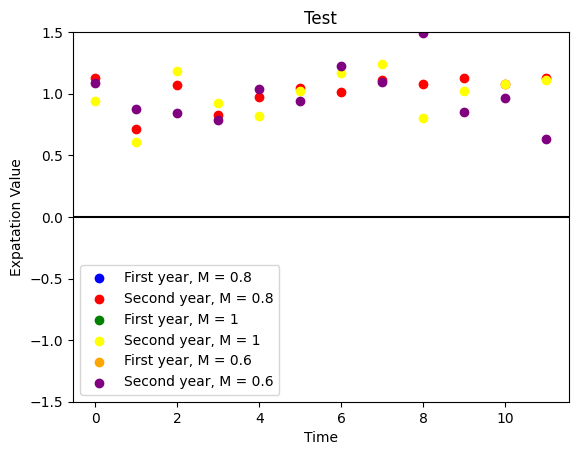

In [10]:
plt.scatter(x_data_first_year, y_data_first_year, c='blue', marker='o', label = "First year, M = 0.8")
plt.scatter(x_data_second_year, y_data_second_year, c='red', marker='o', label = "Second year, M = 0.8")
plt.scatter(x_data_first_year_M1, y_data_first_year_M1, c='green', marker='o', label = "First year, M = 1")
plt.scatter(x_data_second_year_M1, y_data_second_year_M1, c='yellow', marker='o', label = "Second year, M = 1")
plt.scatter(x_data_first_year_M06, y_data_first_year_M06, c='orange', marker='o', label = "First year, M = 0.6")
plt.scatter(x_data_second_year_M06, y_data_second_year_M06, c='purple', marker='o', label = "Second year, M = 0.6")
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
plt.ylim(-1.5, 1.5)
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Expatation Value')
plt.show()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-3001143735.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drift = ((1 + mean[stock_index]) ** 252 - 1) - 0.5 * (std_dev[stock_index] * np.sqrt(252))**2
/tmp/ipython-input-3001143735.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diffusion_const = std_dev[stock_index] * np.sqrt(252)


Processing First Year...
Start simulation (M=0.8)...
Start Optimization (M=0.8)...
Start simulation (M=1)...
Start Optimization (M=1)...
Start simulation (M=0.6)...
Start Optimization (M=0.6)...
Processing Second Year...
Start simulation (M=0.8)...
Start Optimization (M=0.8)...
Start simulation (M=1)...
Start Optimization (M=1)...
Start simulation (M=0.6)...
Start Optimization (M=0.6)...

Check First year M = 0.8 vs M=1
time: 8
daily return value1 idx: 2
daily return correct value idx: 5
Check First year M = 0.6 vs M=1
time: 6
daily return value1 idx: 2
daily return correct value idx: 5
Check Second year M = 0.8 vs M=1
All correct
Check Second year M = 0.6 vs M=1
All correct


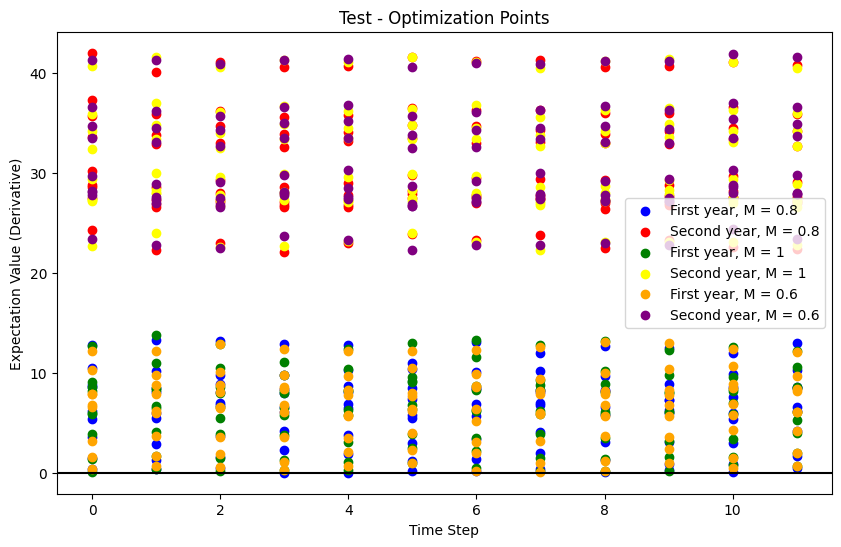

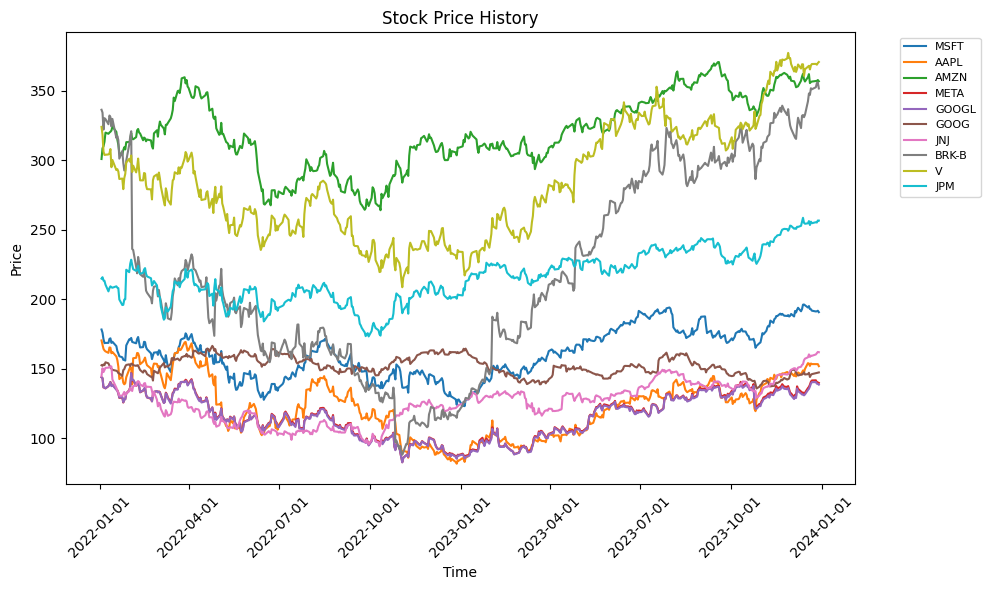

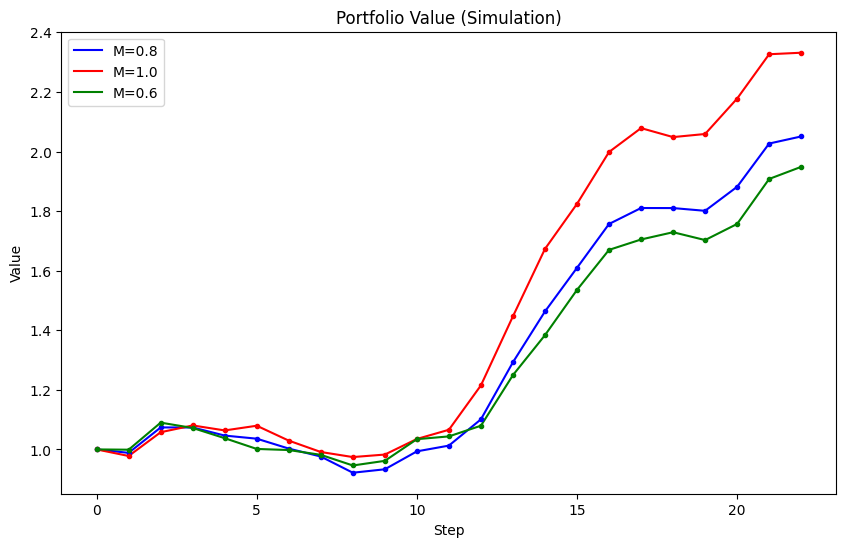

                     Max Drawdown  Log Return  Variances  Sharpe Ratio  \
First Year (M=0.8)      -0.141552    0.012721   0.002128      0.167818   
Second Year (M=0.8)     -0.141552    0.718097   0.157267      2.876276   
First Year (M=1.0)      -0.098260    0.063885   0.001552      0.605755   
Second Year (M=1.0)     -0.098260    0.846552   0.256385      3.147086   
First Year (M=0.6)      -0.131990    0.042791   0.001684      0.400074   
Second Year (M=0.6)     -0.131990    0.667070   0.120088      2.888698   

                     Cumulative Rate of Return (%)  
First Year (M=0.8)                        1.280273  
Second Year (M=0.8)                     105.052737  
First Year (M=1.0)                        6.597012  
Second Year (M=1.0)                     133.159441  
First Year (M=0.6)                        4.371949  
Second Year (M=0.6)                      94.851926  


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib.dates as mdates

# 設定隨機種子以確保結果可重現 (可選)
# np.random.seed(42)

# --- 資料下載區塊 ---
tickers = ['MSFT', 'AAPL', 'AMZN', 'META', 'GOOGL', 'GOOG', 'JNJ', 'BRK-B', 'V', 'JPM']

# 第一年資料
start_date = '2022-01-01'
end_date = '2023-01-01'
data_first_year = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
daily_returns_first_year = data_first_year.pct_change().ffill() # 更新語法
mean_returns_first_year = daily_returns_first_year.mean()
std_returns_first_year = daily_returns_first_year.std()

# 第二年資料
start_date = '2023-01-01'
end_date = '2024-01-03'
data_second_year = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
daily_returns_second_year = data_second_year.pct_change().ffill() # 更新語法
mean_returns_second_year = daily_returns_second_year.mean()
std_returns_second_year = daily_returns_second_year.std()

# 全部資料 (用於畫圖)
start_date = '2022-01-01'
end_date = '2024-01-01'
data_All = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# --- 核心函數：布朗運動模擬與最佳化 ---
def brownian(mean, std_dev, data, group_size, M = 0.8, num_paths = 5000):
    np.random.seed() # 如果需要固定結果，請填入數字，如 np.random.seed(42)
    T = 1.0
    dt = T / len(data.values)

    # 初始化路徑矩陣
    paths = np.zeros((len(tickers), num_paths, len(data.values)))
    predict_return = np.zeros([num_paths, (len(data.values)//group_size), len(tickers)])

    # 1. 蒙地卡羅模擬 (生成路徑)
    print(f"Start simulation (M={M})...")
    for stock_index in range(len(tickers)):
        paths[stock_index, : , 0] = data.iloc[0, stock_index]
        for i in range(num_paths):
            # 這裡計算 drift 和 diffusion
            drift = ((1 + mean[stock_index]) ** 252 - 1) - 0.5 * (std_dev[stock_index] * np.sqrt(252))**2
            diffusion_const = std_dev[stock_index] * np.sqrt(252)

            for j in range(1, len(data.values)):
                dW = np.random.randn() * np.sqrt(dt)
                paths[stock_index,i, j] = paths[stock_index,i, j-1] * np.exp(drift * dt + diffusion_const * dW)

            # 計算分組回報
            for k in range(0, len(data.values) - group_size , group_size):
                returns_sum = 0
                for m in range(group_size):
                    returns_sum += (paths[stock_index, i, k + m + 1] - paths[stock_index, i, k + m]) / paths[stock_index, i, k + m]

                predict_return[i, k//group_size, stock_index] = returns_sum / group_size
        # 進度提示
        # print(f"Stock {tickers[stock_index]} simulation done.")

    # 2. CVXPY 最佳化 (向量化版本)
    x = cp.Variable(len(tickers))
    daily_return_value = [0]*(len(data.values)//group_size)
    daily_return_result = [0]*(len(data.values)//group_size)

    print(f"Start Optimization (M={M})...")
    for i in range (len(data.values)//(group_size)):
        constraints = [cp.sum(x) == 1, x >= 0.00000001, x <= M ]

        # --- 修正開始：使用矩陣運算取代迴圈 ---
        # 取出該時間段所有路徑的預測回報 (shape: 5000 x 10)
        R_matrix = predict_return[:, i, :]

        # 計算投資組合回報 (shape: 5000,)
        # 這裡利用矩陣乘法一次算出所有路徑的組合回報
        port_returns = R_matrix @ x

        # 計算對數效用函數 (一次處理整個向量)
        y = cp.sum(cp.log(1 + port_returns))

        objective = cp.Minimize(-1/num_paths * y)
        # --- 修正結束 ---

        prob = cp.Problem(objective, constraints)

        # 使用 ECOS 或 SCS 求解器以增加穩定性
        try:
            result = prob.solve(solver=cp.ECOS)
        except:
            result = prob.solve(solver=cp.SCS)

        daily_return_value[i] = x.value
        daily_return_result[i] = result

    return daily_return_value, predict_return, paths

# --- 輔助函數 ---
def function_point(daily_return_value, predict_return):
    x_data = []
    y_data = []

    for t in range(len(daily_return_value)):
        # 找出權重最大的股票
        max_idx = np.argmax(daily_return_value[t])

        for j in range(len(tickers)):
            if j == max_idx:
                continue
            x_data.append(t)
            y_value = 0

            # 這裡也可以向量化加速，但維持原樣以確保邏輯正確
            # 分子：最大權重股的回報 - 其他股的回報
            diff = predict_return[:, t, max_idx] - predict_return[:, t, j]
            # 分母：1 + 投資組合回報
            denom = 1 + (predict_return[:, t, :] @ daily_return_value[t])

            y_value = np.sum(diff / denom)
            y_data.append(y_value)

    return x_data, y_data

def function_line(daily_return_value, group_size, daily_returns, value):
    v = value.copy()
    for i in range(1, len(daily_return_value)):
          R_n = np.ones(len(tickers)) # 使用 numpy 初始化
          for j in range(len(tickers)):
              # 計算區間內的累積回報
              start_idx = i * group_size + 1
              end_idx = (i + 1) * group_size + 1
              if end_idx > len(daily_returns): break # 邊界檢查

              # 用 numpy 運算加速乘積
              subset = daily_returns.values[start_idx:end_idx, j]
              R_n[j] = np.prod(1 + subset) - 1

          v_1 = (1 + (np.dot(daily_return_value[i], R_n))) * v[-1]
          v.append(v_1)
    return v

def check_function(daily_return_value1, daily_return_value2):
    a = 1
    for t in range(len(daily_return_value1)):
        # 加入 None 檢查以防求解失敗
        if daily_return_value1[t] is None or daily_return_value2[t] is None:
            continue

        if np.argmax(daily_return_value1[t]) != np.argmax(daily_return_value2[t]):
            print("time:", t)
            print("daily return value1 idx:", np.argmax(daily_return_value1[t]))
            print("daily return correct value idx:", np.argmax(daily_return_value2[t]))
            a = 0
    if a == 1:
        print("All correct")

def Cumulative_rate_of_return(y_data):
    return (y_data[-1] - y_data[0]) / y_data[0]

def variances(y_data):
    return np.var(y_data)

def log_return(y_data):
    return np.log(y_data[-1] / y_data[0])

def sharpe_ratio(y_data, risk_free_rate=0):
    y_data = np.array(y_data)
    daily_returns = (y_data[1:] - y_data[:-1]) / y_data[:-1]
    excess_returns = daily_returns - (risk_free_rate / 252) # 假設無風險利率是年化

    mean_excess_return = excess_returns.mean() * len(y_data) # 這裡依您的邏輯 * len
    annual_std = excess_returns.std() * np.sqrt(len(y_data))

    if annual_std == 0: return 0
    sharpe_ratio = mean_excess_return / annual_std
    return sharpe_ratio

def max_drawdown(y_data):
    y_data = pd.Series(y_data)
    cumulative_max = y_data.cummax()
    drawdown = (y_data - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    return max_drawdown

# --- 主程式執行區塊 ---

group_size = 20

# 執行模型 (這部分會花一點時間，但比原本快很多)
print("Processing First Year...")
daily_return_value_first_year, predict_return_first_year, path_first_year = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size)
daily_return_value_first_year_M1, predict_return_first_year_M1, path_first_year_M1 = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size, M = 1)
daily_return_value_first_year_M06, predict_return_first_year_M06, path_first_year_M06 = brownian(mean_returns_first_year, std_returns_first_year, data_first_year, group_size, M = 0.6)

print("Processing Second Year...")
daily_return_value_second_year, predict_return_second_year, path_second_year = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size)
daily_return_value_second_year_M1, predict_return_second_year_M1, path_second_year_M1 = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size, M = 1)
daily_return_value_second_year_M06, predict_return_second_year_M06, path_second_year_M06 = brownian(mean_returns_second_year, std_returns_second_year, data_second_year, group_size, M = 0.6)

# --- 檢查與繪圖 ---
print("\nCheck First year M = 0.8 vs M=1")
check_function(daily_return_value_first_year, daily_return_value_first_year_M1)
print("Check First year M = 0.6 vs M=1")
check_function(daily_return_value_first_year_M06, daily_return_value_first_year_M1)
print("Check Second year M = 0.8 vs M=1")
check_function(daily_return_value_second_year, daily_return_value_second_year_M1)
print("Check Second year M = 0.6 vs M=1")
check_function(daily_return_value_second_year_M06, daily_return_value_second_year_M1)

# 計算點位 (Function Point)
x_data_first_year, y_data_first_year = function_point(daily_return_value_first_year,predict_return_first_year)
x_data_second_year, y_data_second_year = function_point(daily_return_value_second_year,predict_return_second_year)
x_data_first_year_M1, y_data_first_year_M1 = function_point(daily_return_value_first_year_M1,predict_return_first_year_M1)
x_data_second_year_M1, y_data_second_year_M1 = function_point(daily_return_value_second_year_M1,predict_return_second_year_M1)
x_data_first_year_M06, y_data_first_year_M06 = function_point(daily_return_value_first_year_M06,predict_return_first_year_M06)
x_data_second_year_M06, y_data_second_year_M06 = function_point(daily_return_value_second_year_M06,predict_return_second_year_M06)

# 計算資金曲線 (Function Line)
value_first_year = function_line(daily_return_value_first_year, group_size, daily_returns_first_year, [1])
value_second_year = function_line(daily_return_value_second_year, group_size, daily_returns_second_year, value_first_year)
value_first_year_M1 = function_line(daily_return_value_first_year_M1, group_size, daily_returns_first_year, [1])
value_second_year_M1 = function_line(daily_return_value_second_year_M1, group_size, daily_returns_second_year, value_first_year_M1)
value_first_year_M06 = function_line(daily_return_value_first_year_M06, group_size, daily_returns_first_year, [1])
value_second_year_M06 = function_line(daily_return_value_second_year_M06, group_size, daily_returns_second_year, value_first_year_M06)

# --- 繪圖 1: 散點圖 ---
plt.figure(figsize=(10, 6))
plt.scatter(x_data_first_year, y_data_first_year, c='blue', marker='o', label = "First year, M = 0.8")
plt.scatter(x_data_second_year, y_data_second_year, c='red', marker='o', label = "Second year, M = 0.8")
plt.scatter(x_data_first_year_M1, y_data_first_year_M1, c='green', marker='o', label = "First year, M = 1")
plt.scatter(x_data_second_year_M1, y_data_second_year_M1, c='yellow', marker='o', label = "Second year, M = 1")
plt.scatter(x_data_first_year_M06, y_data_first_year_M06, c='orange', marker='o', label = "First year, M = 0.6")
plt.scatter(x_data_second_year_M06, y_data_second_year_M06, c='purple', marker='o', label = "Second year, M = 0.6")
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
plt.title('Test - Optimization Points')
plt.xlabel('Time Step')
plt.ylabel('Expectation Value (Derivative)')
plt.show()

# --- 繪圖 2: 股價走勢 ---
plt.figure(figsize=(10, 6))
for i in range(len(tickers)):
    plt.plot(data_All.index, data_All.iloc[:, i], label=tickers[i])
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
plt.title('Stock Price History')
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 繪圖 3: 回報曲線 ---
plt.figure(figsize=(10, 6))
# 這裡用 range 當 x 軸，確保長度一致
plt.plot(range(len(value_second_year)), value_second_year, 'b-', label = 'M=0.8')
plt.plot(range(len(value_second_year_M1)), value_second_year_M1, 'r-', label = 'M=1.0')
plt.plot(range(len(value_second_year_M06)), value_second_year_M06, 'g-', label = 'M=0.6')

# 加上點標記
plt.plot(range(len(value_second_year)), value_second_year, 'bo', markersize=3)
plt.plot(range(len(value_second_year_M1)), value_second_year_M1, 'ro', markersize=3)
plt.plot(range(len(value_second_year_M06)), value_second_year_M06, 'go', markersize=3)

plt.legend()
plt.title('Portfolio Value (Simulation)')
plt.xlabel('Step')
plt.ylabel('Value')
plt.show()

# --- 結果表格 ---
results = {
    'Max Drawdown': [
        max_drawdown(value_first_year),
        max_drawdown(value_second_year),
        max_drawdown(value_first_year_M1),
        max_drawdown(value_second_year_M1),
        max_drawdown(value_first_year_M06),
        max_drawdown(value_second_year_M06)
    ],
    'Log Return': [
        log_return(value_first_year),
        log_return(value_second_year),
        log_return(value_first_year_M1),
        log_return(value_second_year_M1),
        log_return(value_first_year_M06),
        log_return(value_second_year_M06)
    ],
    'Variances': [
        variances(value_first_year),
        variances(value_second_year),
        variances(value_first_year_M1),
        variances(value_second_year_M1),
        variances(value_first_year_M06),
        variances(value_second_year_M06)
    ],
    'Sharpe Ratio': [
        sharpe_ratio(value_first_year),
        sharpe_ratio(value_second_year),
        sharpe_ratio(value_first_year_M1),
        sharpe_ratio(value_second_year_M1),
        sharpe_ratio(value_first_year_M06),
        sharpe_ratio(value_second_year_M06)
    ],
    'Cumulative Rate of Return (%)': [
        Cumulative_rate_of_return(value_first_year) * 100,
        Cumulative_rate_of_return(value_second_year) * 100,
        Cumulative_rate_of_return(value_first_year_M1) * 100,
        Cumulative_rate_of_return(value_second_year_M1) * 100,
        Cumulative_rate_of_return(value_first_year_M06) * 100,
        Cumulative_rate_of_return(value_second_year_M06) * 100
    ]
}
df_results = pd.DataFrame(results, index=[
    'First Year (M=0.8)', 'Second Year (M=0.8)',
    'First Year (M=1.0)', 'Second Year (M=1.0)',
    'First Year (M=0.6)', 'Second Year (M=0.6)'
])
print(df_results)

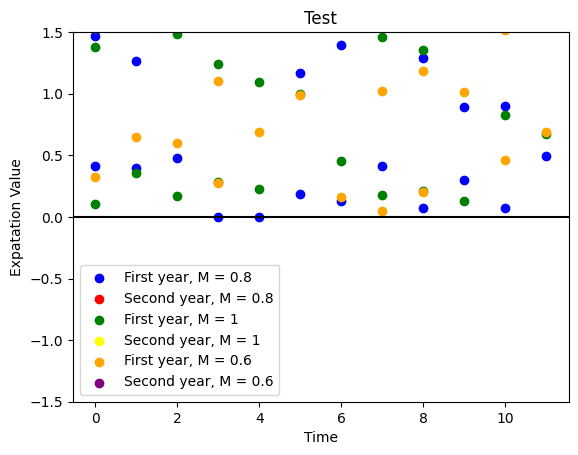

In [6]:
plt.scatter(x_data_first_year, y_data_first_year, c='blue', marker='o', label = "First year, M = 0.8")
plt.scatter(x_data_second_year, y_data_second_year, c='red', marker='o', label = "Second year, M = 0.8")
plt.scatter(x_data_first_year_M1, y_data_first_year_M1, c='green', marker='o', label = "First year, M = 1")
plt.scatter(x_data_second_year_M1, y_data_second_year_M1, c='yellow', marker='o', label = "Second year, M = 1")
plt.scatter(x_data_first_year_M06, y_data_first_year_M06, c='orange', marker='o', label = "First year, M = 0.6")
plt.scatter(x_data_second_year_M06, y_data_second_year_M06, c='purple', marker='o', label = "Second year, M = 0.6")
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
plt.ylim(-1.5, 1.5)
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Expatation Value')
plt.show()